# Analyse the different train/test period experiments

In [138]:
# !pip install netcdf4

In [139]:
# !conda install -c conda-forge shap==0.30

In [140]:
# !conda update matplotlib

In [13]:
from pathlib import Path
import os
import warnings
from typing import Tuple, Optional, Union, Dict, List

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')

assert data_dir.exists()

In [4]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.utils import get_ds_mask

# Get all experiment files

In [86]:
features = [d for d in (data_dir / 'features/').glob('2020*TR*')]
features.sort()
models = [d for d in (data_dir / 'models/').glob('2020*TR*')]
models.sort()

print(f"No. Driving Data:  {len(features)}")
print(f"No. Modelled Data: {len(models)}")

print(features[0])
print(models[0])

No. Driving Data:  27
No. Modelled Data: 27
data/features/2020_02_18:161206_one_month_forecast_TRhigh_TEhigh_LEN51
data/models/2020_02_18:161206_one_month_forecast_TRhigh_TEhigh_LEN51


In [102]:
# get parameters for experiments
test_length = 12
pred_timesteps = 3

train_hilos = [m.name.split('_')[-3][2:] for m in models]
test_hilos = [m.name.split('_')[-2][2:] for m in models]
train_lengths = [int(m.name.split('_')[-1][3:]) for m in models]

In [110]:
from pandas.tseries.offsets import MonthEnd

# GET TEST TIMES
test_times = [
    np.array([
        pd.to_datetime('-'.join(d.name.split('preds_')[-1].replace('.nc', '').split('_'))) + MonthEnd(1)
        for d in (model / 'ealstm').glob('*.nc')
    ])
    for model in models
]

test_times2 = [
    np.array([
        pd.to_datetime('-'.join(d.name.split('_'))) + MonthEnd(1)
        for d in (feature / 'test').iterdir()
    ])
    for feature in features
]

# GET TRAIN TIMES
train_times = [
    np.array([
        pd.to_datetime('-'.join(d.name.split('_'))) + MonthEnd(1)
        for d in (feature / 'train').iterdir()
    ])
    for feature in features
]

# check no. test timesteps is 
assert all([test_length == len(tt) for tt in test_times2])

# check no. train timesteps are equivalent
assert all([np.isclose(train_lengths[i], len(train_times[i]), atol=15) for i in range(len(train_times))])

print(train_lengths)
print([len(train_times[i]) for i in range(len(train_times))])

# TODO: why is the number of model preds.nc objects different?
print([len(test_times[i]) for i in range(len(test_times))])

[51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153]
[51, 114, 154, 51, 114, 154, 51, 113, 153, 51, 114, 153, 51, 113, 154, 51, 110, 154, 51, 115, 155, 51, 112, 153, 51, 114, 156]
[23, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]


## Rebuild experiment objects

In [114]:
from scripts.experiments.experiment import Experiment

In [159]:
sorted_timesteps = pd.date_range('2008-01-01', '2020-01-01', freq='M')
all_experiments = {}
for (
    train_hilo, test_hilo, train_timesteps, test_timesteps, train_length
) in zip(train_hilos, test_hilos, train_times, test_times2, train_lengths):
    
    expt_name = f"one_month_forecast_TR{train_hilo}_TE{test_hilo}_LEN{train_length}"
    e = Experiment(
        train_length=train_length,
        train_hilo=train_hilo,
        test_hilo=test_hilo,
        test_length=12,
        sorted_timesteps=sorted_timesteps,
        pred_timesteps = 3,
    )
    e.train_timesteps = train_timesteps
    e.test_timesteps = test_timesteps
    
    all_experiments[expt_name] = e

not enough high timesteps left! Selecting from other groups
not enough high timesteps left! Selecting from other groups
No more timesteps left for training
not enough high timesteps left! Selecting from other groups
not enough high timesteps left! Selecting from other groups
No more timesteps left for training
not enough high timesteps left! Selecting from other groups
not enough high timesteps left! Selecting from other groups
No more timesteps left for training
not enough med timesteps left! Selecting from other groups
No more timesteps left for training
not enough med timesteps left! Selecting from other groups
No more timesteps left for training
not enough med timesteps left! Selecting from other groups
No more timesteps left for training
No more timesteps left for training
No more timesteps left for training
No more timesteps left for training


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_calculate_hilo_dict', 'get_experiment_timesteps', 'get_test_timesteps_plus', 'plot_experiment_split', 'pred_timesteps', 'print_experiment_summary', 'replacement', 'reshuffle', 'sorted_timesteps', 'test_hilo', 'test_length', 'test_timesteps', 'train_hilo', 'train_length', 'train_timesteps']


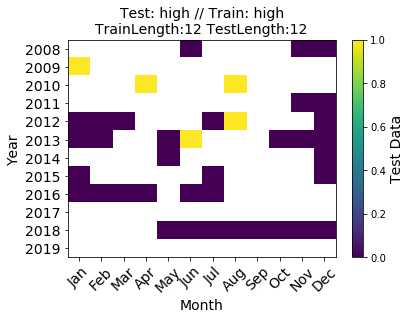

In [126]:
print(dir(all_experiments[0]))

all_experiments[0].plot_experiment_split()

# Load in the data

In [135]:
# Experiment names
experiments = [d.name for d in models]
true_data_experiments = [d.name for d in features]

TARGET_VAR = 'boku_VCI'

# check the experiments are aligned properly
assert all(
    [
        '_'.join(experiments[i].split('_')[3:]) == '_'.join(true_data_experiments[i].split('_')[3:])
        for i in range(len(experiments))
    ]
)

In [133]:
print('_'.join(experiments[0].split('_')[3:]))
print('_'.join(true_data_experiments[0].split('_')[3:]))

one_month_forecast_TRhigh_TEhigh_LEN51
one_month_forecast_TRhigh_TEhigh_LEN51


In [138]:
from src.utils import get_ds_mask

X_train, _ = read_train_data(data_dir, experiment=true_data_experiments[0])
mask = get_ds_mask(X_train.VCI)

In [144]:
import pickle

# ONLY RUN IF DATA NOT SAVED!
if (data_dir / 'tommy/obs_dict.pkl').exists() and (data_dir / 'tommy/model_dict.pkl').exists():
    obs_dict = pickle.load(open(data_dir / 'tommy/obs_dict.pkl', 'rb'))
    model_dict = pickle.load(open(data_dir / 'tommy/model_dict.pkl', 'rb'))
else:
    obs_dict = {}
    model_dict = {}

    for TRUE_EXPERIMENT, EXPERIMENT in zip(true_data_experiments, experiments):
        expt_name = '_'.join(EXPERIMENT.split('_')[3:])
        obs_dict[expt_name] = {}
        model_dict[expt_name] = {}

        # get the observed X, y data
        X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
        X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)

        obs_dict[expt_name]['X_train'] = X_train
        obs_dict[expt_name]['y_train'] = y_train
        obs_dict[expt_name]['X_test'] = X_test
        obs_dict[expt_name]['y_test'] = y_test

        # Get the model predictions
        lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
        bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
        ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

        model_dict[expt_name]['lstm_pred'] = lstm_pred
        model_dict[expt_name]['bline_pred'] = bline_pred
        model_dict[expt_name]['ealstm_pred'] = ealstm_pred

    
    print(f'Saving to {data_dir / "tommy"}')
    with open(data_dir / 'tommy/obs_dict.pkl', 'wb') as fp:
        pickle.dump(obs_dict, fp)
    with open(data_dir / 'tommy/model_dict.pkl', 'wb') as fp:
        pickle.dump(model_dict, fp)

print('** DONE! **')

** DONE! **


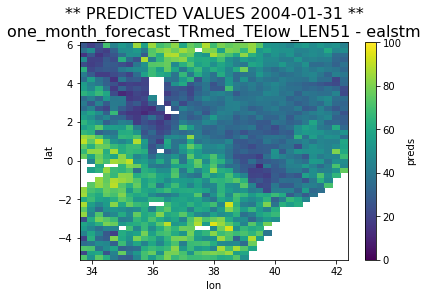

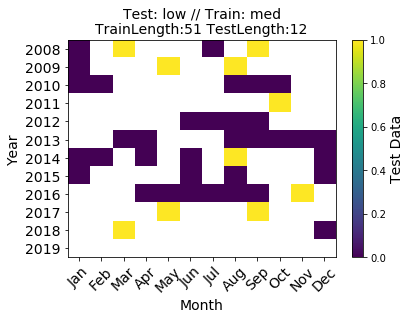

In [177]:
fig, ax = plt.subplots()
time_ix = 1
kwargs = dict(vmin=0, vmax=100, cmap='viridis')

experiment_name = [k for k in model_dict.keys()][-12]
time = model_dict[experiment_name]['ealstm_pred'].time.values
model_dict[experiment_name]['ealstm_pred'].isel(time=time_ix).plot(ax=ax, **kwargs)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0][2:]} **\n{experiment_name} - ealstm", size=16);

all_experiments[experiment_name].plot_experiment_split()

# Model Performance Scores

### Pixel wise performance

In [180]:
assert False, "TODO"

from src.analysis import spatial_rmse, spatial_r2

rmse_dict = {}
r2_dict = {}
for experiment_name in experiment_names:
    rmse_dict[experiment_name] = {}
    r2_dict[experiment_name] = {}
    
    # iterate over each model defined for that experiment
    models = [k for k in model_dict[experiment_name].keys()]
    for model in models:
        # ------- RMSE -------
        model_rmse = spatial_rmse(
            y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
            model_dict[experiment_name][model].transpose("time", "lat", "lon")
        )
        rmse_dict[experiment_name][model] = model_rmse
        
        # ------- R2 -------
        model_r2 = spatial_r2(
            y_test[TARGET_VAR].transpose("time", "lat", "lon").sortby(["time", "lat", "lon"]), 
            model_dict[experiment_name][model].transpose("time", "lat", "lon").sortby(["time", "lat", "lon"])
        )
        r2_dict[experiment_name][model] = model_r2


        # calculate mean performance scores
        model_mean = model_rmse.mean().values
        print(f"{experiment_name} {model} mean RMSE: ".ljust(20), f"{model_mean:.2f}")
        
        model_mean = model_r2.mean().values
        print(f"{experiment_name} {model} mean R2: ".ljust(20), f"{model_mean:.2f}")

AssertionError: TODO

### High Level Overview
* low, med, high train lengths
* 3x3 matrices of (test_hilo vs. train_hilo) 
* expect to see better performance on the 1:1 line

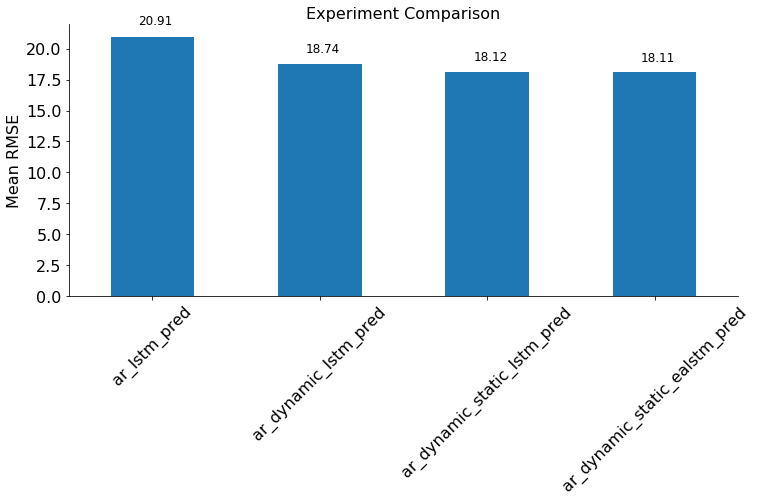

In [78]:
dict_ = {}

for experiment_name in experiment_names:
    models = [k for k in model_dict[experiment_name].keys()]
    for model in models:
        model_rmse = rmse_dict[experiment_name][model]
        dict_[f"{experiment_name}_{model}"] = [np.nanmean(model_rmse.values)]


fig, ax = plt.subplots(figsize=(12, 5))
mean_df = pd.DataFrame(dict_).T.astype(float)
mean_df.plot.bar(ax=ax, legend=False)

ax.set_title('Experiment Comparison: RMSE')
ax.set_ylabel('Mean RMSE');
plt.xticks(rotation=45)

# 
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
             + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",  # annotation (str)
        (p.get_x() + (p.get_width() / 3), p.get_height() * 1.05),  # (x, y) coords
        fontsize=12,
#         fontweight='bold'
    )

## Experiment Parameters
- **Train Length** = short, medium, long
- **Test VCI** = low, medium, high
- **Train VCI** = low, medium, high

#### Hypotheses
* The model performance will improve as the train length gets longer (more data)
* The model will perform better when it is trained on a similar regime to the testing regime (high-high, low-low [TR:TE])
* The model performance will change gradually (better for medium-low than high-low [TR:TE])